In [25]:
# let's work in a dark mode :
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('monokai')

## ✅Introduction:
**Bike Sharing Analysis, teaches you how to analyze data from bike-sharing 
services and identify usage patterns, depending on time features and weather 
conditions.**

**Bike sharing is a fundamental service, commonly used in the urban mobility sector. 
It is easily accessible (as no driving license is required to ride a bike), is cheaper than 
normal car sharing services (since bike maintenance and insurance are substantially 
cheaper than automobile ones), and, finally, is often a fast way to commute within the 
city. Therefore, understanding the driving factors of bike sharing requests is essential 
for both companies and users.**

**From a company's perspective, identifying the expected bike demand in a specific 
area, within a specific time frame, can significantly increase revenue and customer 
satisfaction. Moreover, bike relocation can be optimized to further reduce 
operational costs. From a user's perspective, probably the most important factor is 
bike availability in the shortest wait time, which we can easily see aligning with the 
company's interests.**

**In this chapter, we will analyze bike sharing data from Capital Bikeshare in 
Washington, D.C., USA, for the period between January 1, 2011, and December 31, 2012. The data is aggregated on an hourly basis. This means that no initial and final 
locations of the individual rides are available, but only the total number of rides per 
hour. Nevertheless, additional meteorological information is available in the data, 
which could serve as a driving factor for identifying the total number of requests for a 
specific time frame (bad weather conditions could have a substantial impact on bike 
sharing demand).**
## 1️⃣ Understanding the Data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# laod houly data
hourly_data = pd.read_csv('hour.csv')
hourly_data.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [2]:
# generic statistics & num of missing values:
print(f"shape of data :{hourly_data.shape}")
print(f"Number of missing values in the data: \
{hourly_data.isnull().sum().sum()}")

# get statistics on numeric columns:
hourly_data.describe().T

shape of data :(17379, 17)
Number of missing values in the data: 0


,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


According to the description of the original data ,provided in the Readme.txt file,we can split the columns into 3 main groups:

1. **temporal features :** the time at which the record was registered **[dteday,season,yr,mnth,hr,holiday,weekday,workingday]**.
2. **weather-related features :** the weather condition at which the record was registered **[ weathersit, temp, atemp, hum, windspeed]**.
3. **Record-Related Features** : the number of records for specific hour & date **[casual, registered, cnt]**.

## 2️⃣Data Preprocessing.
>### 💠2.1 Preprocessing Temporal and Weather Features.
 We are going to encode the temporal features into 
a more human-readable format.
- The **seasons** column contains values from 1 to 4, which encode, respectively, the Winter, Spring, Summer, and Fall seasons.
- The **yr** column contains the values 0 and 1 representing 2011 and 2012.
- The **weekday** column contains values from 0 to 6, with each one representing a day of the week (0: Sunday, 1: Monday, through to 6: Saturday).
- The **weathersit** column represents the current weather conditions, where 1 stands for clear weather with a few clouds, 2 represents cloudy weather, 3 relates to light snow or rain, and 4 stands for heavy snow or rain.
-  we scale the **hum** column to values between 0 and 100 (as it represents the humidity percentage).
- The **windspeed** column to values between 0 and 67 (as those are the registered minimum and maximum wind speed by m\sec).

In [3]:
# create a copy of the original data as we don't want a specific Trans. to affect our initial data:
preprocessed_data = hourly_data.copy()

# transform seasons:
seasons_mapping = {1:'winter' , 2:'spring',3:'summer' , 4:'fall'}
preprocessed_data['season'] = preprocessed_data['season'].apply(lambda x :seasons_mapping[x])

#transform yr:
yr_mapping = {0:2011 , 1:2012}
preprocessed_data['yr'] = preprocessed_data['yr'].apply(lambda x : yr_mapping[x])

# transform weekday:
weekday_mapping = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:"Thursday" ,5:'Friday',6:'Saturday'}
preprocessed_data['weekday'] = preprocessed_data['weekday'].apply(lambda x :weekday_mapping[x])

# transform weathersit:
weathersit_mapping = {1:'clear' , 2:'cloudy',3:'light_rain_snow',4:'heavy_rain_snow'}
preprocessed_data['weathersit'] = preprocessed_data['weathersit'].apply(lambda x: weathersit_mapping[x])

# scale hum & windspeed columns:
preprocessed_data['hum'] = preprocessed_data['hum']*100
preprocessed_data['windspeed'] = preprocessed_data['windspeed']*67

# visualize the result of our transformations:
cols = ['season','yr', 'weekday','weathersit', 'hum' ,'windspeed']
preprocessed_data[cols].sample(10,random_state=123)

,season,yr,weekday,weathersit,hum,windspeed
5792,summer,2011,Saturday,clear,74.0,8.9981
7823,fall,2011,Sunday,clear,43.0,31.0009
15426,fall,2012,Tuesday,cloudy,77.0,6.0032
15028,fall,2012,Sunday,clear,51.0,22.0028
12290,spring,2012,Friday,cloudy,89.0,12.9980
3262,spring,2011,Friday,clear,64.0,7.0015
10763,spring,2012,Thursday,clear,42.0,23.9994
12384,spring,2012,Tuesday,light_rain_snow,82.0,11.0014
6051,summer,2011,Wednesday,clear,52.0,19.0012
948,winter,2011,Saturday,clear,80.0,0.0000


>### 💠2.2 Registered versus Casual Use Analysis.
We begin our analysis of the single features by focusing on the two main ones: 
the number of rides performed by **registered** users versus the number of rides 
performed by non-registered (or **casual**) ones. These numbers are represented in the 
registered and casual columns, respectively, with the **cnt** column representing 
the sum of the registered and casual rides.
- **What is a Distribution in Statistics?**
A distribution in statistics is a function that shows the possible values for a variable and how often they occur.

In [4]:
"""
assert that total number of rides is equal to the sum of registered & casual ones
"""
assert (preprocessed_data.casual + preprocessed_data.registered == preprocessed_data.cnt).all(),\
        'Sum of casual and registered rides not equal to total number of rides'

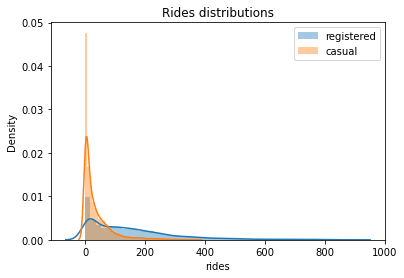

In [5]:
# plot distributions of registered vs casual rides.
sns.distplot(preprocessed_data['registered'],label='registered')
sns.distplot(preprocessed_data['casual'],label='casual')
plt.xlabel('rides')
plt.title('Rides distributions')
plt.legend();

📝Insights:
- 📌 Registered users perform way more rides than casual ones.
- 📌 The two distributions are skewed to the right,meaning that,for most of the entries,\
    zero or small number of rides were registered.
- 📌 Every entry in the data has quite a large number of rides (that is, higher than 800).


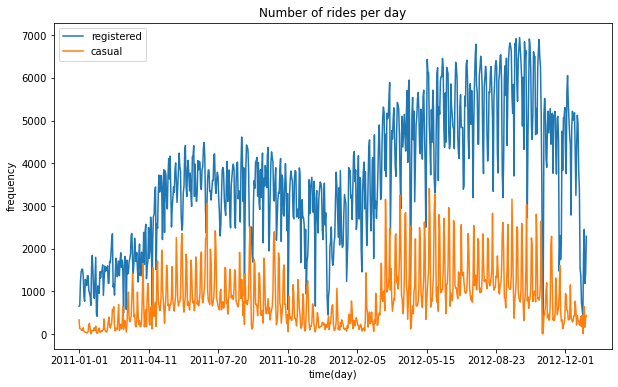

In [6]:
# plot the evolution of rides over time.
plot_data = preprocessed_data[['dteday','registered', 'casual']]
ax = plot_data.groupby('dteday').sum().plot(figsize=(10,6))
ax.set_xlabel('time(day)')
ax.set_ylabel('frequency')
plt.title('Number of rides per day');

 📝 Insights:
 - 📌 The num of registered rides is higher than the num of casual rides per day.
 - 📌 We can observe that during winter,the over all num of rides decreases(where bad weather takes place).
 - 📌There is quite a lot of **variance** in the timeseries, **one way to smooth out this curve is to take the rolling mean & std**\
 [How to Calculate a Rolling Mean in Pandas and how it is calculated.](https://www.statology.org/rolling-mean-pandas/#:~:text=A%20rolling%20mean%20is%20simply%20the%20mean%20of,we%20can%20use%20the%20following%20syntax%3A%20df%20%5B%27column_name%27%5D.rolling%28rolling_window%29.mean%28%29).


In [7]:
plot_data = preprocessed_data[['dteday','registered', 'casual']]
plot_data = plot_data.groupby('dteday').sum()

# get the rolling means:
plot_data[0:8] , plot_data.rolling(7).mean()[0:8]

(            registered  casual
 dteday                        
 2011-01-01         654     331
 2011-01-02         670     131
 2011-01-03        1229     120
 2011-01-04        1454     108
 2011-01-05        1518      82
 2011-01-06        1518      88
 2011-01-07        1362     148
 2011-01-08         891      68,
              registered      casual
 dteday                             
 2011-01-01          NaN         NaN
 2011-01-02          NaN         NaN
 2011-01-03          NaN         NaN
 2011-01-04          NaN         NaN
 2011-01-05          NaN         NaN
 2011-01-06          NaN         NaN
 2011-01-07  1200.714286  144.000000
 2011-01-08  1234.571429  106.428571)

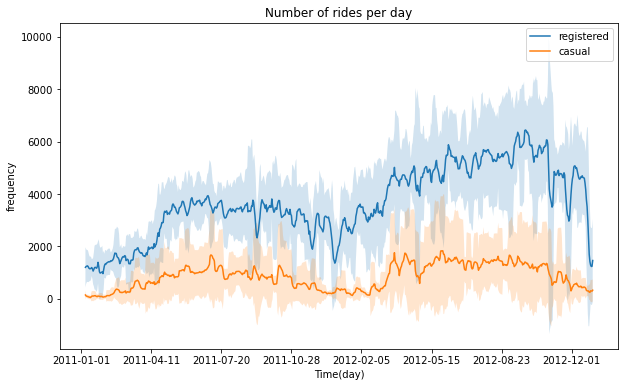

In [8]:
plot_data = preprocessed_data[['dteday','registered', 'casual']]
plot_data = plot_data.groupby('dteday').sum()

# creating window for computing mean & std which means ,get the mean/std of the last 7 days & put it in the 7th day & so on.

window = 7
rolling_means = plot_data.rolling(7).mean()
rolling_std  = plot_data.rolling(7).std()

"""Create a plot of the series, where we first plot the series of rolling 
means, then we color the zone between the series of rolling means +- 2 
rolling standard deviations
"""
ax = rolling_means.plot(figsize=(10,6))
ax.fill_between(rolling_means.index , rolling_means['registered']+2*rolling_std['registered'],
                                      rolling_means['registered']-2*rolling_std['registered'],alpha=0.2)

ax.fill_between(rolling_means.index , rolling_means['casual']+2*rolling_std['casual'],
                                      rolling_means['casual']-2*rolling_std['casual'],alpha=0.2)
ax.set_xlabel('Time(day)')
ax.set_ylabel('frequency')
plt.title('Number of rides per day');

In [9]:
# Focusing on the distribution of rides requests over days of the week and hours of the days:
plot_data = preprocessed_data[['weekday','hr','registered','casual']]
plot_data.melt(['weekday','hr'],var_name='type',value_name='count')

,weekday,hr,type,count
0,Saturday,0,registered,13
1,Saturday,1,registered,32
2,Saturday,2,registered,27
3,Saturday,3,registered,10
4,Saturday,4,registered,1
...,...,...,...,...
34753,Monday,19,casual,11
34754,Monday,20,casual,8
34755,Monday,21,casual,7
34756,Monday,22,casual,13


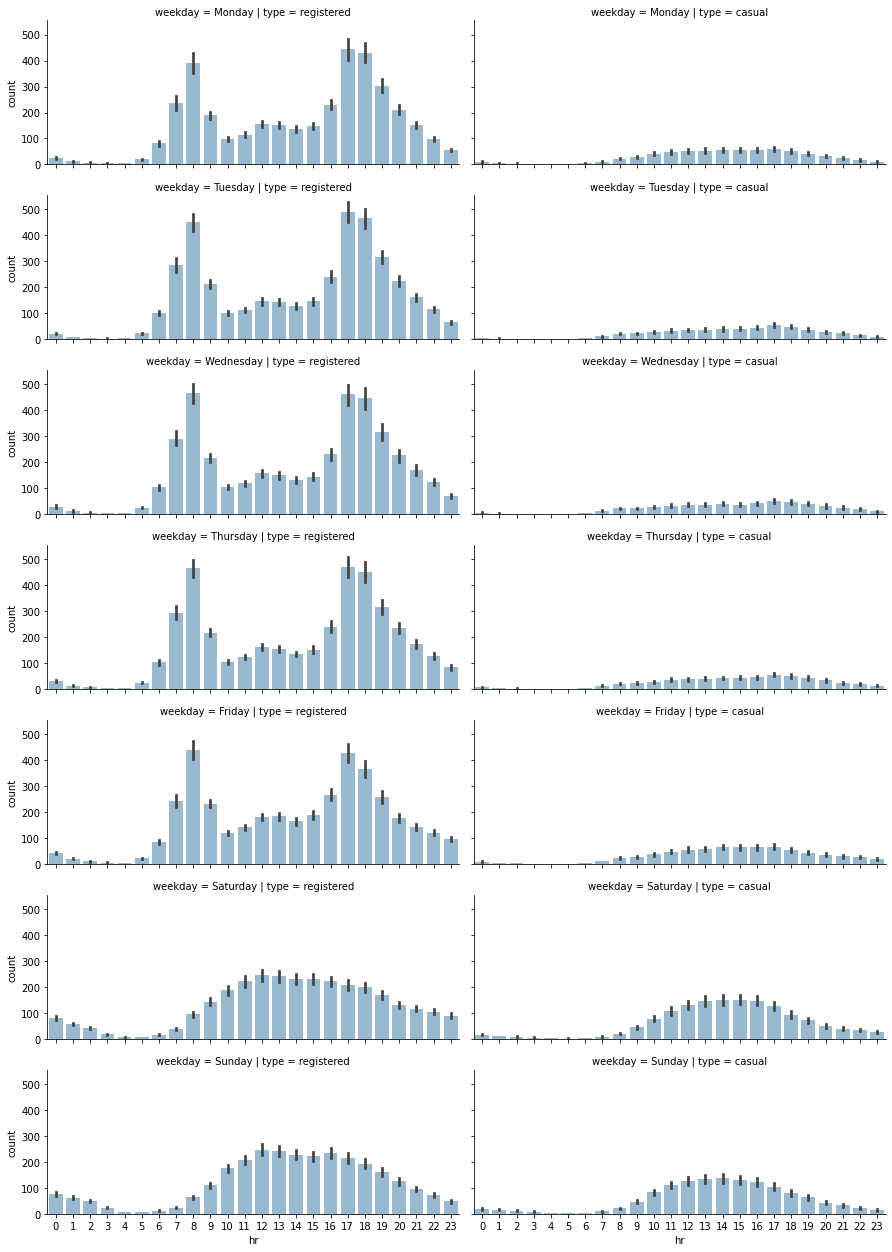

In [10]:
plot_data = preprocessed_data[['weekday','hr','registered','casual']]
plot_data = plot_data.melt(['weekday','hr'],var_name='type',value_name='count')

"""Create a FaceGrid object ,in which grid plot is produced.
   AS columns, we have the various days of the week, As rows ,the different users types.
"""

grid = sns.FacetGrid(plot_data,row='weekday',col='type',height=2.5,aspect=2.5,
                     row_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                          'Friday', 'Saturday', 'Sunday'])      
# fill the FaceGrid with specific plot (barplot).
grid.map(sns.barplot,'hr','count',alpha=0.5);

📝 insights:
- 📌 We can immediately note that on working days, the highest number of rides takes place around 8Am & 6Pm.\
This is totaly in line with our expectation as most of the registered users use the bake sharing service for commuting.
- 📌 On contrary, the casual usage of bike sharing is quite limited in working days and rises in weekends as we expected.
- 📌 As conclusion, we can claim that the most of the usage of the bike sharing services occures during working days,\
right before & right after the working time(9Am to 5pm).

>### 💠2.3 Analyzing seasonal impact on rides.
We are going to investigate the impact of the different seasons on the activity of bike sharing usage over\
**hours of the day** and  **days of the week**.

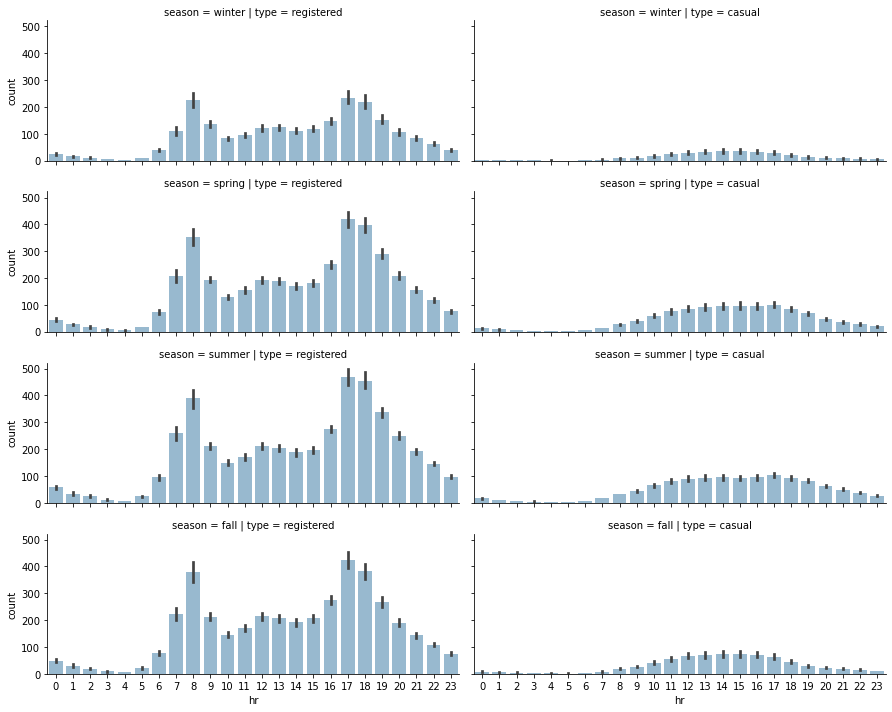

In [11]:
plot_data = preprocessed_data[['hr','season','registered','casual']]
plot_data = plot_data.melt(id_vars=['season','hr'],var_name='type',value_name='count')

# create a Facetgrid where seasons= rows , type= columns then, fill it with barplot(x=hr , y=count).
grid = sns.FacetGrid(plot_data,row='season',col='type',height=2.5,aspect=2.5)
grid.map(sns.barplot,'hr','count',alpha=0.5);

- As can be seen in the plot, while each season has relativly similar grapg shape,the count is lower\
for winter graph as fewer rides are likely to occur when weather is poor.

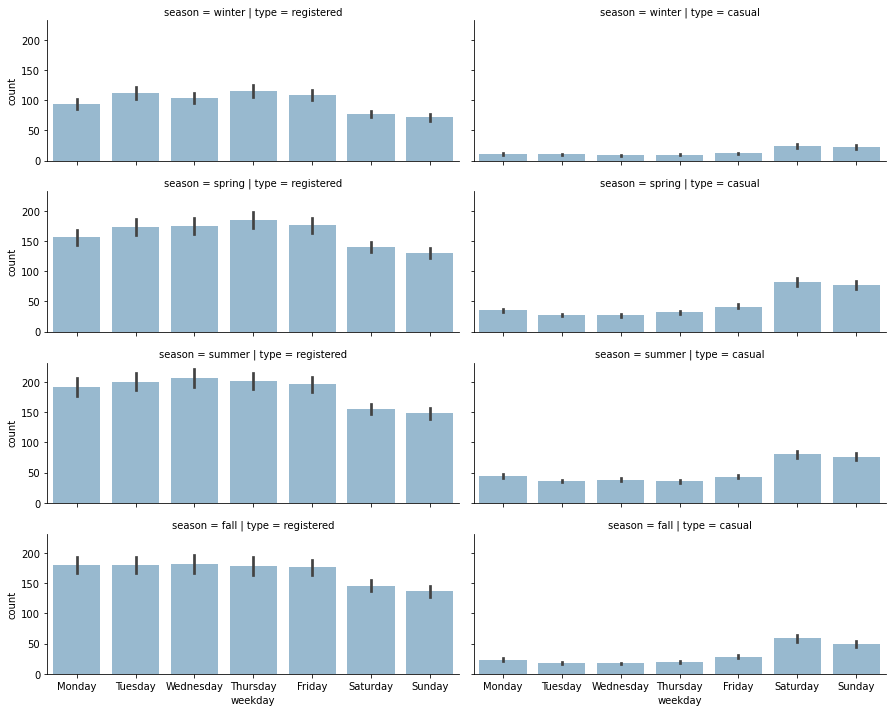

In [12]:
# see the density of rides for each season over week days.
plot_data = preprocessed_data[['weekday','season','registered','casual']]
plot_data = plot_data.melt(id_vars=['season','weekday'],var_name='type',value_name='count')

# create a Facetgrid where seasons= rows , type= columns then, fill it with barplot(x=hr , y=count).
grid = sns.FacetGrid(plot_data,row='season',col='type',height=2.5,aspect=2.5)
grid.map(sns.barplot,'weekday','count',order=['Monday', 'Tuesday', 'Wednesday',\
                                              'Thursday','Friday', 'Saturday', 'Sunday'],alpha=0.5);

📝**An interesting pattern occurs from the analysis conducted, Analyzing 
Seasonal Impact on Rides. There is a decreasing number of registered rides over 
the weekend (compared to the rest of the week), while the number of casual rides 
increases. This could enforce our initial hypothesis, that is, that registered customers 
mostly use the bike sharing service for commuting (which could be the reason for the 
decreasing number of registered rides over the weekend), while casual customers 
use the service occasionally over the weekend. Of course, such a conclusion cannot 
be based solely on plot observations but has to be backed by statistical tests, which is 
the topic of our next section.**

## 3️⃣Hypothesis Tests.
>### 💠3.1 Estimating Average Registered Rides.
Computing the average num of registered rides per hour.
- H0 : mean of num of rides done by registered users = 153.7
- H1 : mean of num of rides done by registered users != 153.7

In [13]:
# compute population mean of registered rides.
population_mean = preprocessed_data['registered'].mean()
print(f'True mean of the population = {population_mean}')
# get sample of the data (EX: summer 2011).
sample = preprocessed_data[(preprocessed_data['season'] == 'summer') & (preprocessed_data['yr']==2011)].registered

# perform t-test and compute p-value.
from scipy.stats import ttest_1samp
test_result = ttest_1samp(sample,population_mean)
test_result

True mean of the population = 153.78686920996606


Ttest_1sampResult(statistic=-3.491969148378619, pvalue=0.0004887645279519517)

Important notes :
- While the null hypothesis is equal to the true mean of the population,Where it is more likely to be proven\
by the test, the p-value = 0.0005 which is less than our significance value = 0.05 hence, we had to reject\
the Null.

- **why???? :**The answer to that question lies in the fact that your **sample is not a true representation of the population**, but rather a biased one. In fact, you selected only entries from the summer of 2011. Therefore, neither data from the full year is present, nor entries from 2012. 

In [14]:
# get sample as 5% of the full data & perform t-test
import random 
random.seed(111)
unbaised_sample = preprocessed_data.registered.sample(frac=0.05)
test_result = ttest_1samp(unbaised_sample,population_mean)
test_result

Ttest_1sampResult(statistic=-0.8749936629256846, pvalue=0.3818193991728064)

- In this time, we tried to get a well represented sample which leads to p_value = 0.25 much larger than our critical 0.05 resulting in not rejecting the null stated above.

>### 💠3.2 Hypothesis Testing on Registered Rides.
- Is there  a statistically significant difference between num of registered rides during **wordingdays\weekends**.\
**H_0 :** average registered rides over weekdays **-** average registered rides over 
weekend **=** 0.  \
**H_a** : average registered rides over weekdays **-** average registered rides over 
weekend **≠** 0.


In [15]:
# define mask, indicating if the day is weekend or workday.
weekend_days = ['Saturday','Sunday']
weekend_mask = preprocessed_data.weekday.isin(weekend_days) 
workingday_mask = ~weekend_mask

# select the registered rides for weekends\workingdays.
weekend_data = preprocessed_data.registered[weekend_mask]
workingdays_data = preprocessed_data.registered[workingday_mask]

# perform the 2-sample ttest:
from scipy.stats import ttest_ind
test_result = ttest_ind(weekend_data , workingdays_data)
print(f'statistic value = {test_result[0]:.03f}, p-value = {test_result[1]:.03f}')

statistic value = -16.004, p-value = 0.000


- Once the p-val is less than 0.05 we have the right to neglect the null and admitting the alternative one.That is going in line with the insights captured from the above figures, that the num of rides increses in the working days .

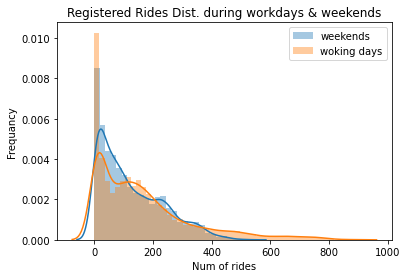

In [16]:
# plot distributions of registered rides for working vs weekend days.
sns.distplot(weekend_data,label='weekends')
sns.distplot(workingdays_data,label='woking days')
plt.xlabel('Num of rides')
plt.ylabel('Frequancy')
plt.title('Registered Rides Dist. during workdays & weekends')
plt.legend();

- perform the same type of hypothesis testing to validate the second assumption from the last section - that is casual users perform more rides during the weekend:\
**H_0 :** average casual rides over weekdays **-** average registered rides over 
weekend **=** 0.  \
**H_a** : average casual rides over weekdays **-** average registered rides over 
weekend **≠** 0.

statistic value = 41.077, p-value = 0.000


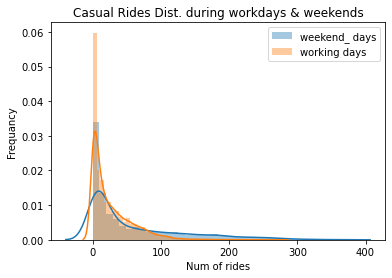

In [17]:
# 1. create a mask that indicate workingdays & weekends. [The same as we did above 'No time to waste']
# 2. select num of casual rides in weekend days & working days:
weekend_data = preprocessed_data.casual[weekend_mask]
workingdays_data = preprocessed_data.casual[workingday_mask]
# 3.perform ttest:
test_result = ttest_ind(weekend_data,workingdays_data)
print(f'statistic value = {test_result[0]:.03f}, p-value = {test_result[1]:.03f}')

# 4. plot
sns.distplot(weekend_data,label='weekend_ days')
sns.distplot(workingdays_data,label='working days')
plt.xlabel('Num of rides')
plt.ylabel('Frequancy')
plt.title('Casual Rides Dist. during workdays & weekends')
plt.legend();

- **Hence, we can conclude that casual 
customers also behave differently over the weekend (in this case, they tend to 
use the bike sharing service more)In conclusion, we can say that there is a statistically significant difference between 
the number of rides on working days and weekend days for both casual and 
registered customers.**

## 3️⃣Analysis of Weather-Related Features.
Let's now focus on an analysis of the group of features representing the weather 
conditions. Our expectation is to observe a strong dependency of those features on 
the current number of rides, as bad weather can significantly influence bike 
sharing services.

- As we want to examine the correlation between num of rides for (registered & casual) and the different weather conditions.

- So, let's first define a **function** to get the correlstion between any condition col & our cols of interest num (registered & casual) rides,as we want to follow **the don't repeat yourself principle**.

array([[1.        , 0.33536085],
       [0.33536085, 1.        ]])

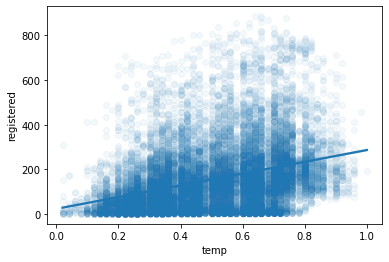

In [18]:
# Try the the idea of the function befor excution: 
corr_registered = np.corrcoef( preprocessed_data['registered'],
                              preprocessed_data['temp'])

ax = sns.regplot(x='temp',y='registered',data=preprocessed_data,
                 scatter_kws={'alpha':0.05} ,
        label=f'Registered rides(correlation = {corr_registered[0,1]:.03f})')

corr_registered

<AxesSubplot:title={'center':'Correlation between Rides & windspeed'}, xlabel='windspeed', ylabel='num of rides'>

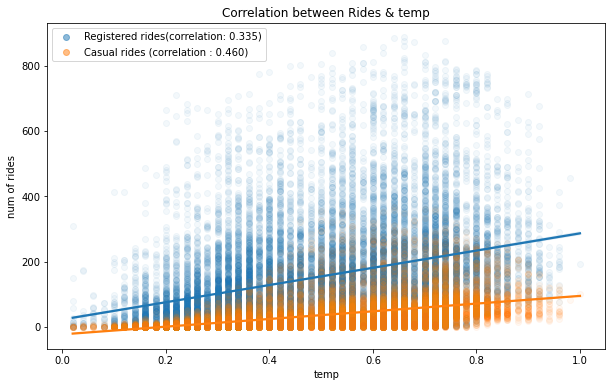

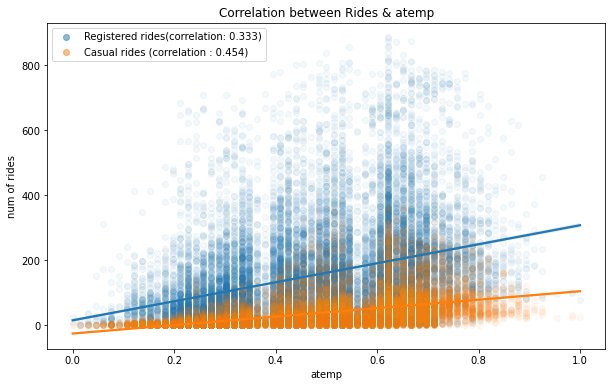

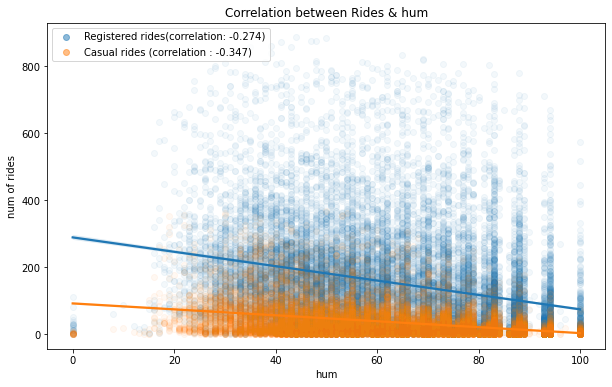

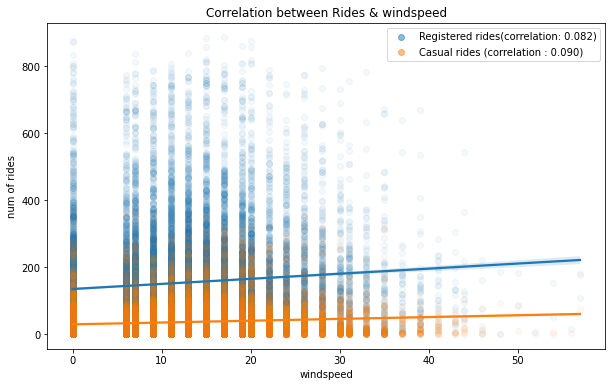

In [19]:
def plot_correlations(data,col):
# get correlation between col & registered rides ,then plot it.
    plt.figure(figsize=(10,6))

    corr_r = np.corrcoef(data['registered'] , data[col])[0,1]
    ax = sns.regplot(x = col , y= 'registered' , data=data,
                     scatter_kws={'alpha':0.05},
                     label=f"Registered rides(correlation: {corr_r:.3f})")
    
# get correlation between col & casual rides , then plot it also.
    corr_c = np.corrcoef(data['casual'],data[col])[0,1]
    ax = sns.regplot(x= col , y='casual' , data=data,
                     scatter_kws={'alpha':0.05},
                     label = f'Casual rides (correlation : {corr_c:.3f})')
    
# To make the legend visable where it's not clear where alpha = 0.05
    legend = ax.legend()
    for lh in legend.legendHandles:
        lh.set_alpha(0.5)
        
    ax.set_ylabel('num of rides')
    ax.set_title(f'Correlation between Rides & {col}')
    return ax

plot_correlations(preprocessed_data,'temp')
plot_correlations(preprocessed_data,'atemp')
plot_correlations(preprocessed_data,'hum')
plot_correlations(preprocessed_data,'windspeed')

📝Insights: 
- 📌We can observe that higher temperatures have a positive impact 
on the number of rides (the correlation between registered/casual rides and temp is 
0.335 and 0.46, respectively, and it's a similar case for atemp). Note that as the values 
in the registered column are widely spread with respect to the different values 
in temp, we have a lower correlation compared to the casual column. The same 
pattern can be observed in Humidity figure in which the humidity level has a negative 
correlation with both types of rides (-0.274 for registered and -0.347 for casual). 
This means that with a high level of humidity (mist or rain), customers will tend not 
to use the bike sharing service. From windspeed figure, we can see that there is minimal 
correlation between the number of rides and the wind speed (a weak 
positive correlation).\

📝One of the major drawbacks of the **pearson corr** that it assumes a linear relationship between 2 variables.So we are in need of trying a brand new correlation type **Spearman corr** that can capture a monotonic relationship.

>### 💠3.1 Evaluating the Difference between the Pearson and Spearman Correlations.
- Pearson corr : a linear relationship between 2 variable is assumed.
- Spearman corr : a monotonic relationship is required.\
This will help understanding the difference between both,especially when the data doesn't satisfy linear assumption.

Text(0.5, 1.0, 'Monotonic relationship \n pearson : 0.856 ,spearman :1.0')

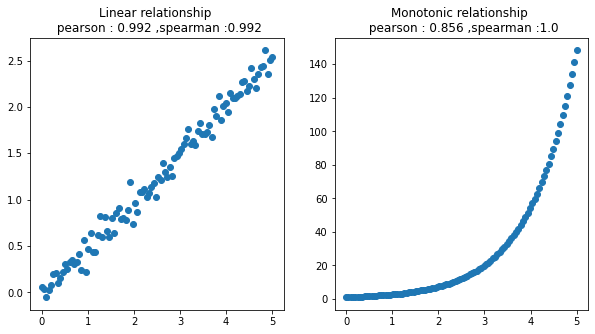

In [20]:
# Define random variables:
x = np.linspace(0,5,100)
y_linear = 0.5*x + 0.1*np.random.randn(100)
y_monotonic  = np.exp(x) + 0.1*np.random.randn(100)

# compute correlations ,1st: assume it's linear ,2nd: it's monotonic.
# These functions returns the corr_val & p-val of null says corr_val = 0.
from scipy.stats import pearsonr, spearmanr 
# 1st:
linear_pearson = pearsonr(x,y_linear)[0]
linear_spearman = spearmanr(x,y_linear)[0]
# 2nd : 
monotonic_pearson = pearsonr(x,y_monotonic)[0]
monotonic_spearman = spearmanr(x,y_monotonic)[0]

# visualize the data with computed correlation.
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.scatter(x,y_linear)
ax1.set_title(f'Linear relationship \n pearson : {linear_pearson:.3} ,spearman :{linear_spearman:.3}')
ax2.scatter(x,y_monotonic)
ax2.set_title(f'Monotonic relationship \n pearson : {monotonic_pearson:.3} ,spearman :{monotonic_spearman:.3}')

📝Insights:
- 📌As you can see from the preceding figure, when the relationship between the 
two variables is linear (the figure on the left), the two correlation coefficients 
are very similar. In the monotonic relationship (the figure on the right), the 
linear assumption of the Pearson correlation fails, and, although the correlation 
coefficient is still quite high (0.856), it is not capable of capturing the perfect 
relationship between the two variables. On the other hand, the Spearman 
correlation coefficient is 1, which means that it succeeds in capturing the almost 
perfect relationship between the two variables.

**In the light of that information, let's make the projection onto our problem of interest.**

In [21]:
# define a function that compute the (pearson & spearman) corr for all weather-related features.
def compute_corr(data,col):
    pearson_registered = pearsonr(data[col],data['registered'])[0]
    pearson_casual = pearsonr(data[col],data['casual'])[0]
    
    spearman_registered = spearmanr(data[col],data['registered'])[0]
    spearman_casual = spearmanr(data[col],data['casual'])[0]
    return pd.Series({'pearson_registered':pearson_registered , 'spearman_registered':spearman_registered,
                      'pearson_casual':pearson_casual, 'spearman_casual': spearman_casual})

df = pd.DataFrame()
for col in  ["temp", "atemp", "hum", "windspeed"]:
    col_df = compute_corr(preprocessed_data,col).to_frame(name= col)
    df = pd.concat([df , col_df],axis=1)
df.T

,pearson_registered,spearman_registered,pearson_casual,spearman_casual
temp,0.335361,0.373196,0.459616,0.570989
atemp,0.332559,0.373014,0.454080,0.570419
hum,-0.273933,-0.338480,-0.347028,-0.388213
windspeed,0.082321,0.122936,0.090287,0.122920


📝Insights \
**For registered users :** 
- 📌 Pearson & spearman corr are quite the same .

**For casual users :** 
- 📌 The most striking difference is between (temp & atemp).More precisly,the spearman coeff is quite high, meaning that there is significant evidence for nonlinear , relatively strong and positive relationship.

**📝General conclution :**
An interpretation of this result is that casual customers are far keener on using the 
bike sharing service when temperatures are higher. We have already seen from our 
previous analysis that casual customers ride mostly during the weekend, and they 
do not rely on bike sharing services for commuting to work. This conclusion is again 
confirmed by the strong relationship with temperature, as opposed to registered 
customers, whose rides have a weaker correlation with temperature

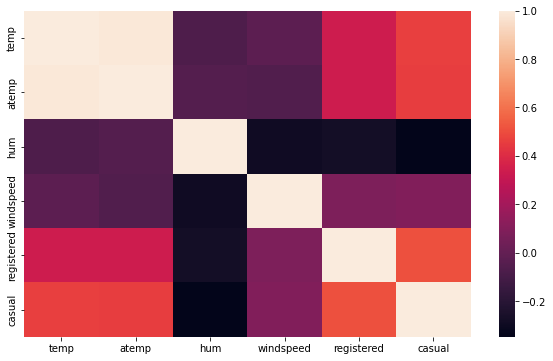

In [22]:
# let's plot a correlation matrix.
cols = ["temp", "atemp", "hum", "windspeed",'registered','casual']
corrs = preprocessed_data[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corrs);

## 4️⃣ Time Series Analysis.
an important concept is the notion of stationarity.In order to check stationarity in practice, we can rely on two different techniques for identifying time series stationarity: rolling statistics and augmented Dickey-Fuller stationarity test (in most cases, we consider both of them).
- **Rolling statistics:** is a practical method in which we plot the rolling mean and 
standard deviation of a time series and visually identify whether those values 
fluctuate around a constant one, without large deviations. We have to inform the 
reader that this is more a rule-of-thumb approach and not a rigorous statistical test 
for stationarity.
- **Augmented Dickey-Fuller stationarity test** is a statistical test in which the null 
hypothesis is that the time series is nonstationary. Hence, when performing the test, 
a small p-value would be strong evidence against the time series being nonstationary.

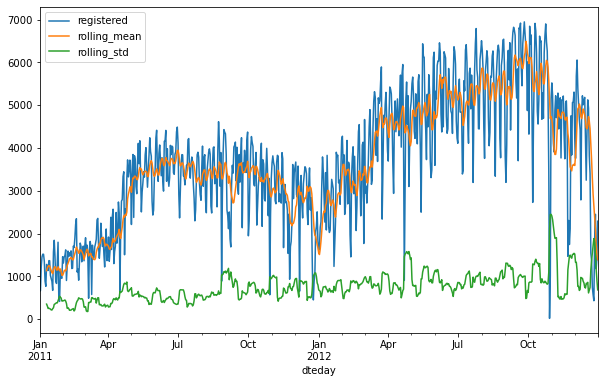

In [23]:
from statsmodels.tsa.stattools import adfuller
# check the logic of the function befor excution:
ts1 = preprocessed_data[['dteday','registered']].groupby('dteday').sum()
ts2 = preprocessed_data[['dteday','registered']].groupby('dteday').sum()

registered_df = pd.DataFrame(ts1)
# The index of 'registered_rides' is a 'string', So we should convert them as 'DateTime' 
# object for better visualization later.
registered_df['rolling_mean'] = ts1.rolling(10).mean()
registered_df['rolling_std'] = ts2.rolling(10).std()
registered_df.index = pd.to_datetime(registered_df.index)

ax = registered_df.plot(figsize=(10,6))

In [24]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(ts,window=10):
    # put the time series into datafarme to plot it easily
    ts_df = pd.DataFrame(ts)
    ts_df['roling_mean'] = ts.rolling(window).mean()
    ts_df['rolling_std'] = ts.rolling(window).std()
    ts_df.plot(figsize=(10,6))
    # compute p-val with null=there is a nonstationary timeseries with respect to num rides(Registered \ Casual).         
    p_value = adfuller(ts)[1]
    plt.title(f'Agum. Dick-fuller p-value :{p_value:.3f}')

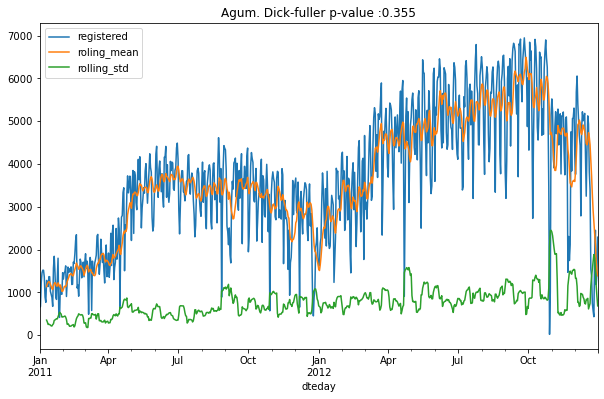

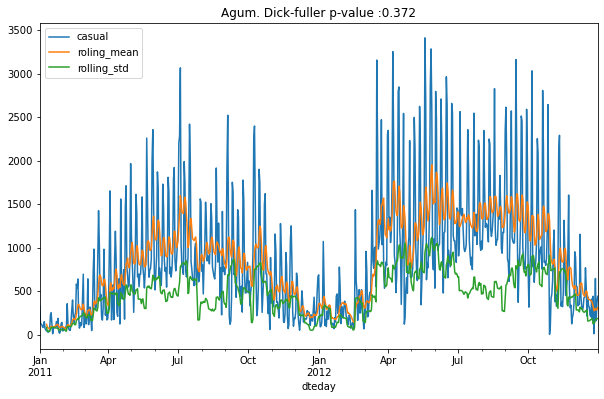

In [25]:
# preparing the data, then plot:
daily_data = preprocessed_data[['dteday','registered','casual']].groupby('dteday').sum()
daily_data.index = pd.to_datetime(daily_data.index)
for col in ['registered','casual']:
    test_stationarity(daily_data[col])

📝Insights:
- 📌 From the performed tests, we can see that neither the moving average nor standard 
deviations are stationary. Furthermore, the Dickey-Fuller test returns values of 0.355 
and 0.372 for the registered and casual columns, respectively. This is strong 
evidence that the time series is not stationary, and we need to process them in order 
to obtain a stationary one.

- 📌 A common way to detrend a time series and make it stationary is to subtract either its 
rolling mean or its last value, or to decompose it into a component that will contain its 
trend, seasonality, and residual components.

Let's first check whether the time series 
is stationary by **subtracting their rolling means** and **last values**:

####  APPROACH 1 : subtracting rolling mean.

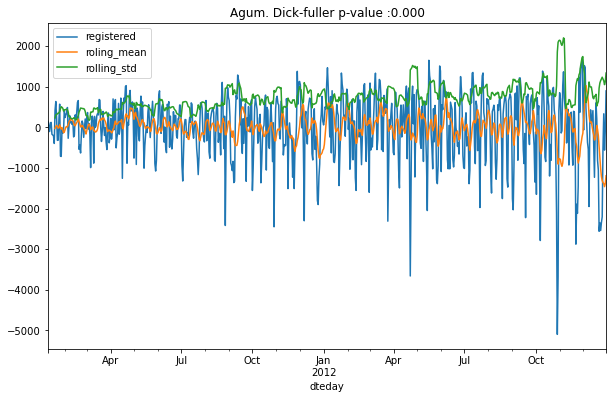

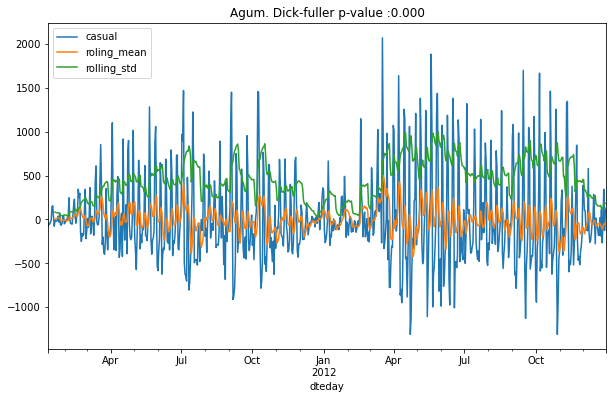

In [26]:
# 1st : for 'registered' rides:
registered = daily_data['registered']
registered_mean = registered.rolling(10).mean()
registered_mean_diff = registered - registered_mean
# remove all NaN values resulted from subtraction , then it's ready to plot:
registered_mean_diff = registered_mean_diff.dropna()

# 2nd : for 'casual' rides:
casual = daily_data['casual']
casual_mean = casual.rolling(10).mean()
casual_mean_diff = casual - casual_mean
# remove all NaN values resulted from subtraction , then it's ready to plot:
casual_mean_diff = casual_mean_diff.dropna() 

# plot using 'test_stationarity()':
for diff in [registered_mean_diff,casual_mean_diff]:
    test_stationarity(diff)

####  APPROACH 2 : subtracting the last value.

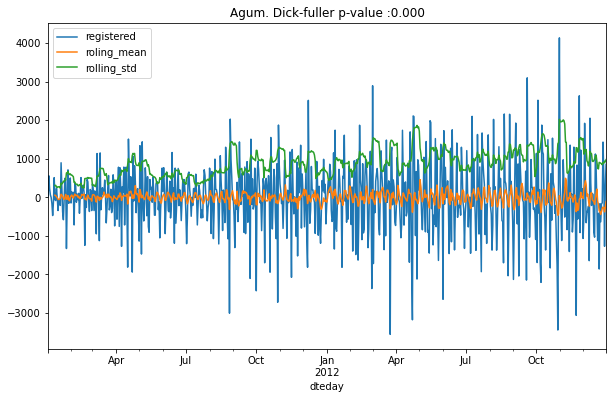

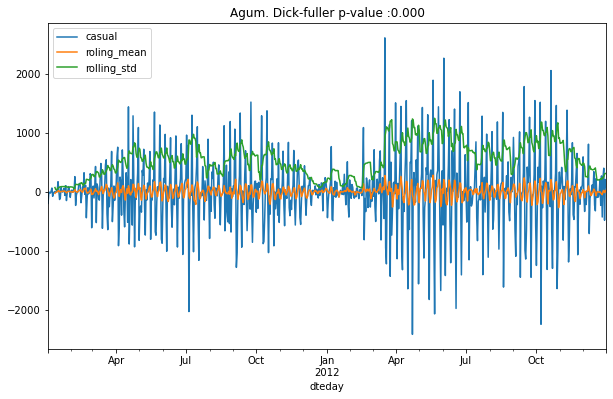

In [27]:
# 1st: for 'registered' rides.
registered = daily_data['registered']
registered_diff = registered - registered.shift()
registered_diff = registered_diff.dropna()

# 2st: for 'casual' rides.
casual = daily_data['casual']
casual_diff = casual - casual.shift()
casual_diff = casual_diff.dropna()

for diff in [registered_diff , casual_diff] :
    test_stationarity(diff)

**📝Insights**
- 📌 Both of the techniques returened a time series, which is stationary according to the P_val resulted from Dickey-Fuller test.
- 📌 An interesting pattern occurs in the casual series: a rolling_std exhibits a clustering effect [volatility clustering], that is,  periods in which `std` is higher and periods in which it is lower.Which means that the nummber of casual rides increases during the summer and drops during the winter.

####  APPROACH 3 :  time series Decomposition.
This approach involves breaking the original time-series into 3 separate components :
- `Trend_comp` : it is present when there is persistent increase\decrease in the series.
- `Seasonal_comp` : it represents seasonality patterns in the data. it persists when the data is influenced by certain seasonal factors (Monthly,Quarterly,or Yearly).
- `Residual_comp` : This component represents an irregular or noisy 
component. This component describes random fluctuations in the data, which 
are not captured by the other components. In general, this is the residual of the 
time series, that is, once the other components have been removed.
![1](1.png)
![2](2.png)

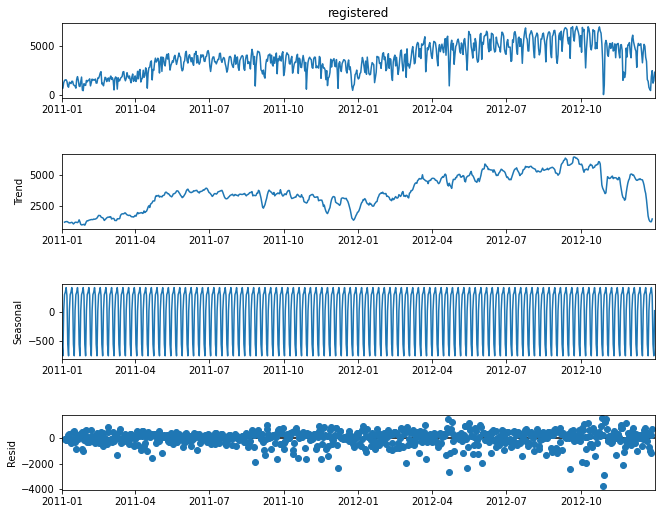

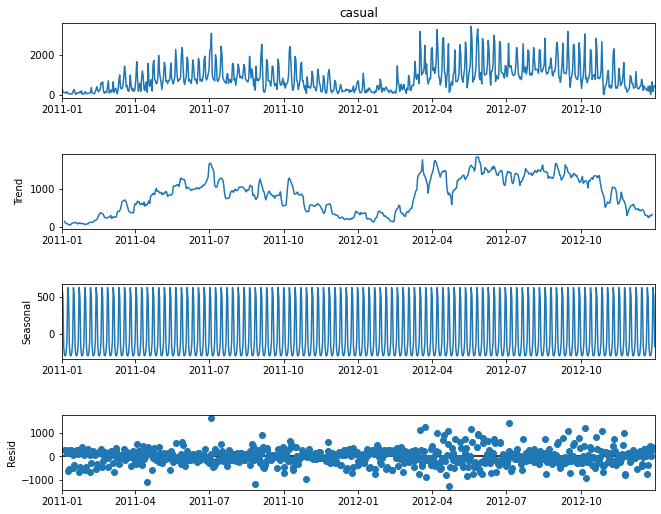

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
# seasonal_decompose() function stores the 3 comp and you can access each one using[.trend,.seasonal ,.resid]     
registered_decomposition = seasonal_decompose(daily_data['registered'])
casual_decomposition = seasonal_decompose(daily_data['casual'])

# plot decompositions:
for decomp in [registered_decomposition , casual_decomposition]:
    decomp.plot().set_size_inches(10,8)

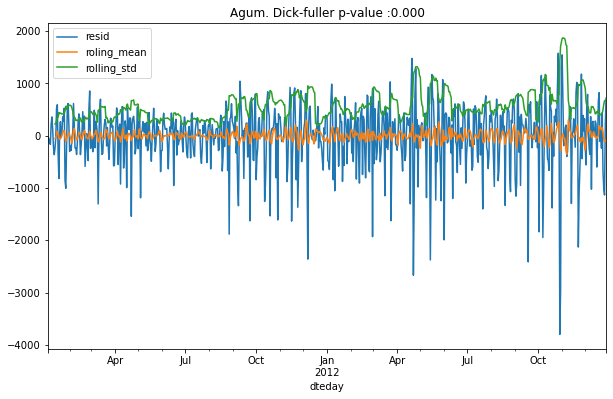

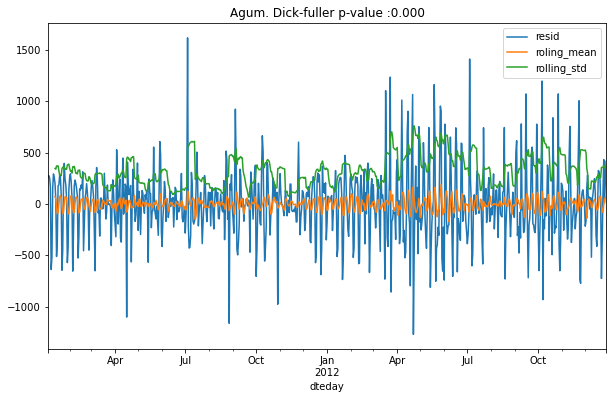

In [29]:
# Test the residuals for stationarity:
for decomp in [registered_decomposition , casual_decomposition]:
    test_stationarity(decomp.resid.dropna())

**📝Insights**
- 📌 As you can see the residuals satisfy our Stationary Test with p_val=0.

## 5️⃣ ARIMA Models.
**This is a class of statistical models that try to explain the behavior of a time series using its own past values. Being a class of models, ARIMA models are defined by a set of parameters (p,d,q), each one corresponding to a different component to create an ARIMA model.**
- `Autoregressive of order (p)` : it models the current time series entry as a linear combination of its last p values. 
- `Moving average of order (q)` : it attempts to model the current value of the time series as a linear 
combination of its past error terms.
- `Integrated component of order (d)` : it is a transformation in the original time series, in which the transformed series is obtained by getting the difference between Yt and Y(t-d). This integration term is used for detrending the original time series and making it stationary. Note as we did previously at **APPROACH 2 : subtracting the last value.** when we subtracted the previous entry of in the number of rides.

**How to perform an ARIMA model in practice:**
1. Integrate the original time series of order d, and then obtain the new series.
2. Apply a combination of the AR(p) and MA(q) models, also known as ARMA(p,q), to the transformed series.

```
A standard method for finding the parameters (p,d,q) of an ARIMA model is to compute the autocorrelation and partial autocorrelation functions (ACF and PACF for short). The autocorrelation function measures the Pearson correlation between the lagged values in a time series as a function of the lag.

In practice, the ACF measures the complete correlation between the current entry, Yt, and its past entries, lagged by k . Note that when computing the ACF(k), the correlation between Yt with all intermediate values (Y(t-1),…,Y(t-k+1)) is not removed. In order to account only for the correlation between and Y(t-k), we often refer to the PACF, which only measures the impact of Y(t-k) on Yt.

ACF and PACF are, in general, used to determine the order of integration when modeling a time series with an ARIMA model. For each lag, the correlation coefficient and level of significance are computed. In general, we aim at an integrated series, in which only the first few lags have correlation greater than the level of significance
```
**Applying a ACF & PACF for registered_TimeSeries :**

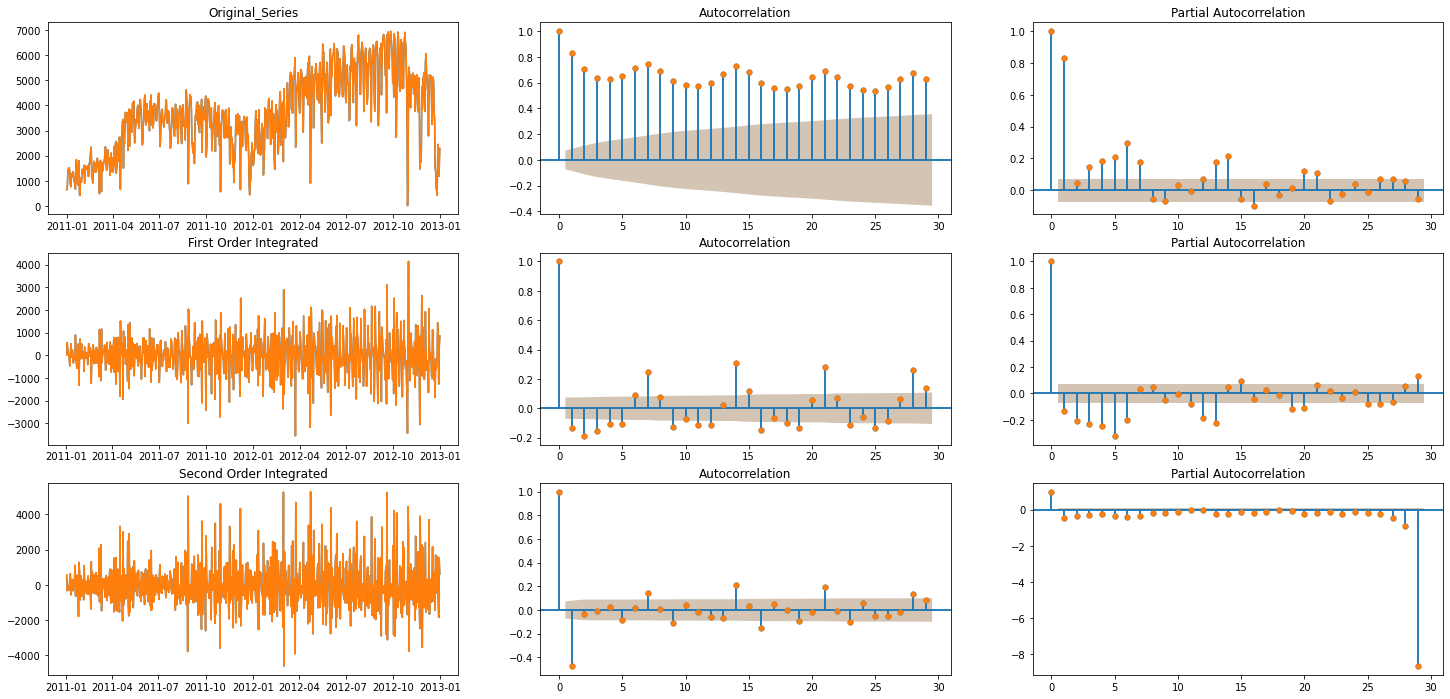

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#fig, axes = plt.subplots(3, 3, figsize=(25, 12))

# plot the original time series:
original  = daily_data['registered']
axes[0,0].plot(original)
axes[0,0].set_title('Original_Series')
plot_acf(original, ax=axes[0,1])
plot_pacf(original , ax=axes[0,2])

# plot first order integrated series:
first_order  = original.diff().dropna()
axes[1,0].plot(first_order)
axes[1,0].set_title('First Order Integrated')
plot_acf(first_order, ax=axes[1,1])
plot_pacf(first_order , ax=axes[1,2])

# plot second order integrated series:
second_order  = first_order.diff().dropna()
axes[2,0].plot(second_order)
axes[2,0].set_title('Second Order Integrated')
plot_acf(second_order, ax=axes[2,1])
plot_pacf(second_order , ax=axes[2,2])

**📝Insights**
- 📌 As you can see from the preceding figure, the original series exhibits several 
autocorrelation coefficients that are above the threshold. The first order 
integrated series has only a few, which makes it a good candidate for further 
modeling (hence, selecting an ARIMA(p,1,q) model). Finally, the second order 
integrated series present a large negative autocorrelation of lag 1, which, in 
general, is a sign of too large an order of integration.

- 📌Now focus on finding the model parameters and the coefficients for an 
ARIMA(p,d,q) model, based on the observed registered rides. The general 
approach is to try different combinations of parameters and chose the one that 
minimizes certain information criterion, for instance, the Akaike Information 
Criterion (AIC) or the Bayesian Information Criterion (BIC).

```
conda install -c saravji pmdarima

from pmdarima import auto_arima
model = auto_arima(registered, start_p=1, start_q=1, \
                   max_p=3, max_q=3, information_criterion="aic")
print(model.summary())
```
![3](3.png)

**📝Insights**
- 📌 As you can see, the best selected model was ARIMA(3,1,3), with the coef column 
containing the coefficients for the model itself.

- Finally, evaluate how well the number of rides is approximated by the model by 
using the model.predict_in_sample() function :
```
# plot original and predicted values
plot_data = pd.DataFrame(registered)
plot_data['predicted'] = model.predict_in_sample()
plot_data.plot(figsize=(12, 8))
plt.ylabel("number of registered rides")
plt.title("Predicted vs actual number of rides")
```
![4](4.png)

**📝Insights**
- 📌As you can see, the predicted column follows the original one quite well, although 
it is unable to correctly model a large number of rise and fall movements in the 
registered series.